In [1]:
from Preprocessing_Module import read_data, add_topological, add_landcover, merge_new_data, fill_data, select_columns, reshape_dataset, fillna_dataset, remove_nan_features, unused_stations
from Feature_Expansion_Module import feature_expansion
from Initializer_Module import initializer
from XGboost_Model_Module import Xgboost_model
from Neural_Network_Module import FeedforwardNeuralNetModel
from Model_Validation_Module import give_predictions_nn, evaluate_nn, give_predictions_xgboost, evaluate_xgboost, validate_results, merge_predictions
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

In [ ]:
# original backup cell from Argyro
# Run the Next

data = read_data('../Datasets/Germany/GER_wuerttemberg_culex_2010_2023.csv')
data = merge_new_data('../Datasets/Germany/monthly_data/GER_culex_ento_2024_05_processed.csv', data)
data = merge_new_data('../Datasets/Germany/monthly_data/GER_culex_ento_2024_06_processed.csv', data)
data = merge_new_data('../Datasets/Germany/monthly_data/GER_culex_ento_2024_07_processed.csv', data)
data = merge_new_data('../Datasets/Germany/monthly_data/GER_culex_ento_2024_08_processed.csv', data)
data = merge_new_data('../Datasets/Germany/monthly_data/GER_culex_ento_2024_09_processed.csv', data)
data = merge_new_data('../Datasets/Germany/monthly_data/GER_env_2024_10_2km_processed.csv', data)
columns = ['dt_placement', 'x', 'y', 'culex.spp', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
           'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
           'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
           'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
           'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
           'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
names = ['dt_placement', 'x', 'y', 'mosq_now', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
         'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
         'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
         'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
         'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
         'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
data = select_columns(data,columns,names)
data = add_topological(data,'../Datasets/Topological Datasets/2x2grid/germany_wuerttemberg_2km_geo.csv')
data = add_landcover(data,'../Datasets/Landcover Datasets/2x2grid/germany_wuerttemberg_2km_lulc.csv')
data = reshape_dataset(data,['x','y','dt_placement'])
data = fillna_dataset(data,{'acc_rainfall_1week':0, 'acc_rainfall_2week':0, 'acc_rainfall_jan':0})

In [3]:
data = read_data('../Datasets/Germany/GER_wuerttemberg_culex_2010_2024.csv')
data = merge_new_data('../Datasets/Germany/monthly_data/GER_culex_ento_2025_05_processed.csv', data)
# data = merge_new_data('../Datasets/Germany/monthly_data/GER_culex_ento_2024_06_processed.csv', data)
# data = merge_new_data('../Datasets/Germany/monthly_data/GER_culex_ento_2024_07_processed.csv', data)
# data = merge_new_data('../Datasets/Germany/monthly_data/GER_culex_ento_2024_08_processed.csv', data)
# data = merge_new_data('../Datasets/Germany/monthly_data/GER_culex_ento_2024_09_processed.csv', data)
data = merge_new_data('../Datasets/Germany/monthly_data/GER_env_2025_06_2km_processed.csv', data)
columns = ['dt_placement', 'x', 'y', 'culex.spp', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
           'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
           'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
           'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
           'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
           'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
names = ['dt_placement', 'x', 'y', 'mosq_now', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
         'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
         'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
         'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
         'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
         'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
data = select_columns(data,columns,names)
data = add_topological(data,'../Datasets/Topological Datasets/2x2grid/germany_wuerttemberg_2km_geo.csv')
data = add_landcover(data,'../Datasets/Landcover Datasets/2x2grid/germany_wuerttemberg_2km_lulc.csv')
data = reshape_dataset(data,['x','y','dt_placement'])
data = fillna_dataset(data,{'acc_rainfall_1week':0, 'acc_rainfall_2week':0, 'acc_rainfall_jan':0})

Index(['station_id', 'x', 'y', 'dt_placement', 'week', 'month', 'year',
       'country_code', 'nuts0_code', 'nuts0_name', 'nuts1_code', 'nuts1_name',
       'nuts2_code', 'nuts2_name', 'nuts3_code', 'nuts3_name',
       'lau1_municipality', 'lau2_settlement', 'trap_type', 'culex.spp',
       'region', 'dt_placement_original', 'indices_image_date', 'indices_lat',
       'indices_lon', 'ndvi', 'ndmi', 'ndwi', 'ndbi', 'ndvi_mean', 'ndmi_mean',
       'ndwi_mean', 'ndbi_mean', 'ndvi_std', 'ndmi_std', 'ndwi_std',
       'ndbi_std', 'lst_image_date', 'lst_lat', 'lst_lon', 'lst_day',
       'lst_night', 'monthly_lst_lat', 'monthly_lst_lon', 'lst_jan_day_mean',
       'lst_jan_night_mean', 'lst_feb_day_mean', 'lst_feb_night_mean',
       'lst_mar_day_mean', 'lst_mar_night_mean', 'lst_apr_day_mean',
       'lst_apr_night_mean', 'indices_image_date.1', 'indices_lat.1',
       'indices_lon.1', 'acc_rainfall_jan', 'dt_placement_minus_7',
       'dt_placement_minus_14', 'dt_placement_minus_7_avail

In [4]:
# set the date of prediction for the test set
date = '2025-06-02'

# set the filename for export
case = 'Culex_Germany_'

# set the filename to export
path = './predictions/Germany/'
        
title = date[:-3].replace('-','_')
title = case + title

# set the name of the date column
date_col = 'dt_placement'
# set the model type. Could be 'class_regression' or 'mosquito_regression' or 'classification'
model_type = 'class_regression'

In [5]:
data = feature_expansion(data)

In [6]:
data = initializer(data, model_type, [-1,   1.,  3.,  8.,  11., 16., 23., 37., 78., 206., np.inf])

Bounds: [ -1.   1.   3.   8.  11.  16.  23.  37.  78. 206.  inf]


In [7]:
print("#===========================================")
print("Performance of the previous month")
print("#===========================================")
print()
# validate_results(path+case + date[:-3].replace(date[:-3].split('-')[1],str(int(date[:-3].split('-')[1])-1)).replace('-','_')+'.csv',data)
validate_results(path+case+'2025_05.csv',data)

#===========================================
Performance of the previous month
#===========================================

Mean time difference in days: 1.4333333333333333
-------------------
Overall MAE: 1.5333333333333334
Overall % error <=3: 80.0
number of observations: 30
-------------------
MAE without entomological: 1.5333333333333334
% error <=3 without entomological: 80.0
number of observations: 30
-------------------


Features Dropped: ['ndvi', 'ndwi', 'ndmi', 'ndbi', 'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean', 'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night', 'lst']
#===========================================
Predictions without entomological features
#===========================================

Epoch 001: | Train Loss: 7.41206 | Val Loss: 5.68731 | Train Acc: 1.507| Val Acc: 1.395
Epoch 002: | Train Loss: 5.11370 | Val Loss: 4.04250 | Train Acc: 1.390| Val Acc: 1.281
Epoch 003: | Train Loss: 4.28385 | Val Loss: 3.72927 | Train Acc: 1.320| Val Acc: 1.223
Epoch 004: | Train Loss: 4.07478 | Val Loss: 3.45717 | Train Acc: 1.295| Val Acc: 1.177
Epoch 005: | Train Loss: 3.75464 | Val Loss: 3.31580 | Train Acc: 1.246| Val Acc: 1.147
Epoch 006: | Train Loss: 3.66940 | Val Loss: 3.13295 | Train Acc: 1.238| Val Acc: 1.133
Epoch 007: | Train Loss: 3.57229 | Val Loss: 3.01952 | Train Acc: 1.210| Val Acc: 1.126
Epoch 008: | Train Loss: 3.44493 | Val Loss: 2.99909 | Train Acc: 1.

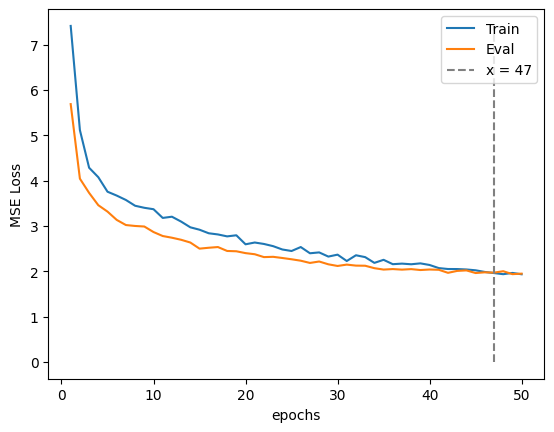

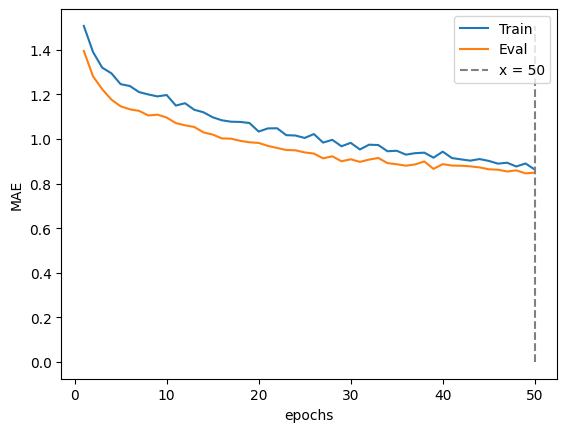

MAE on train set:  0.6781196581196581
min prediction: 0
max prediction: 9

MAE on test set:  0.8475734791524265
Error <= 3: 96.24 %
min prediction: 0
max prediction: 9


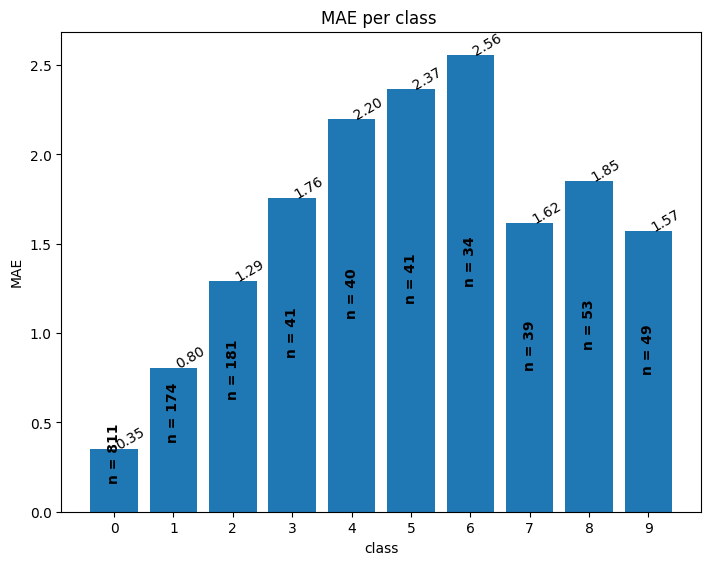

-----------|class error-MAE| difference-----------
mean: 0.5183329916245606
std: 0.39807949375975743
coefficient of variation (std/mean): 0.7679995296307411

----------normalized difference-------------
mean: 0.42443046205865154
std: 0.3259623952220025


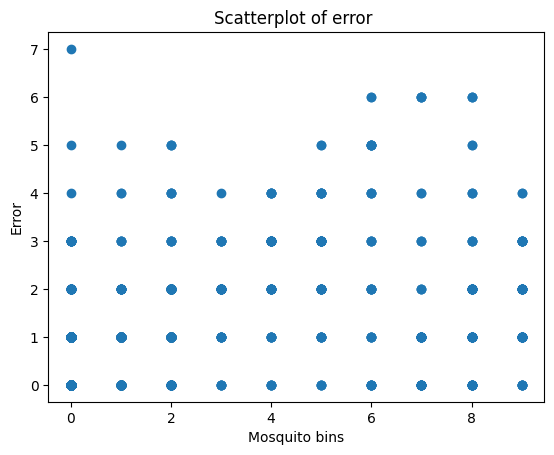

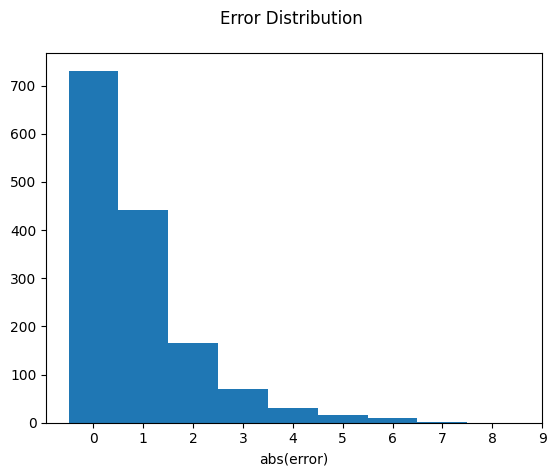

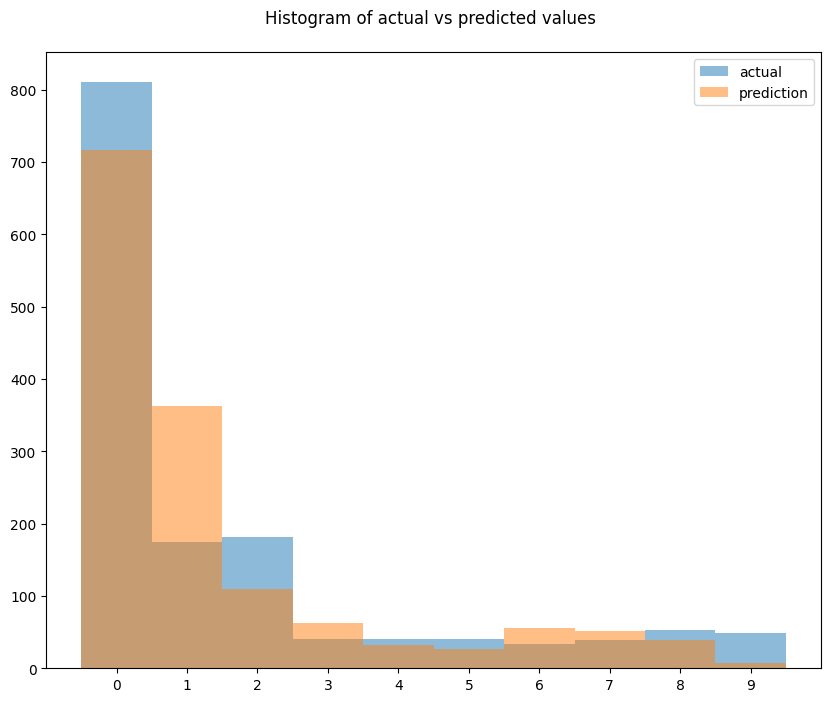

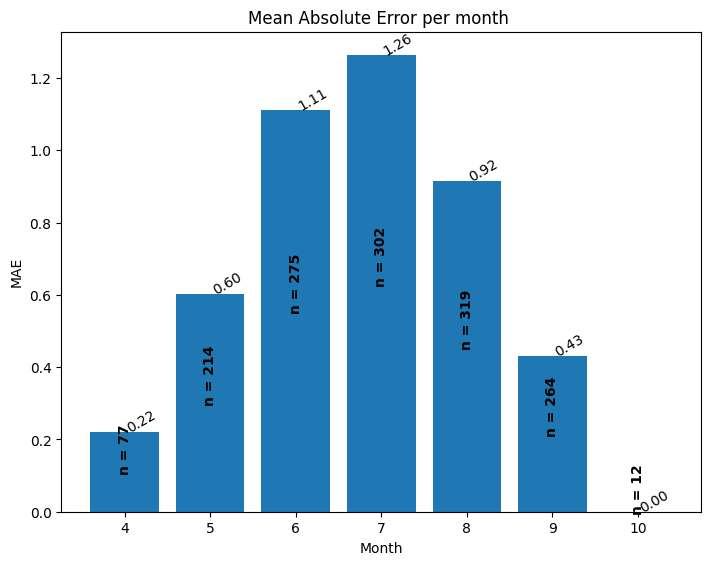

prediction
0    3124
1    2006
2     905
3     687
4     563
5     394
6     213
7     108
8      31
9      16
Name: count, dtype: int64

Low risk category stations: 5130
Medium risk category stations: 2549
High risk category stations: 368
#===========================================
Predictions with entomological features
#===========================================

Epoch 001: | Train Loss: 7.17209 | Val Loss: 6.24673 | Train Acc: 1.588| Val Acc: 1.469
Epoch 002: | Train Loss: 5.27182 | Val Loss: 4.67759 | Train Acc: 1.439| Val Acc: 1.326
Epoch 003: | Train Loss: 4.42054 | Val Loss: 3.95944 | Train Acc: 1.345| Val Acc: 1.270
Epoch 004: | Train Loss: 4.07873 | Val Loss: 3.69843 | Train Acc: 1.300| Val Acc: 1.222
Epoch 005: | Train Loss: 3.68513 | Val Loss: 3.46959 | Train Acc: 1.242| Val Acc: 1.163
Epoch 006: | Train Loss: 3.62348 | Val Loss: 3.42506 | Train Acc: 1.221| Val Acc: 1.178
Epoch 007: | Train Loss: 3.53053 | Val Loss: 3.30451 | Train Acc: 1.213| Val Acc: 1.142
Epoch 008: | 

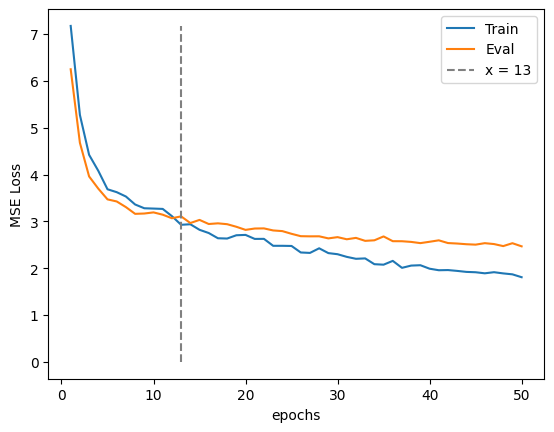

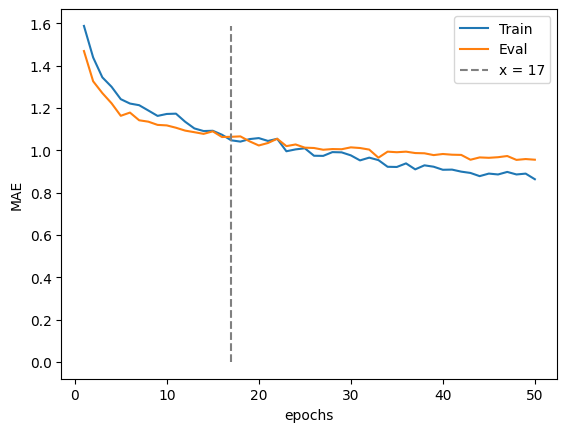

MAE on train set:  0.6915656690576305
min prediction: 0
max prediction: 9

MAE on test set:  0.9564787339268052
Error <= 3: 94.76 %
min prediction: 0
max prediction: 9


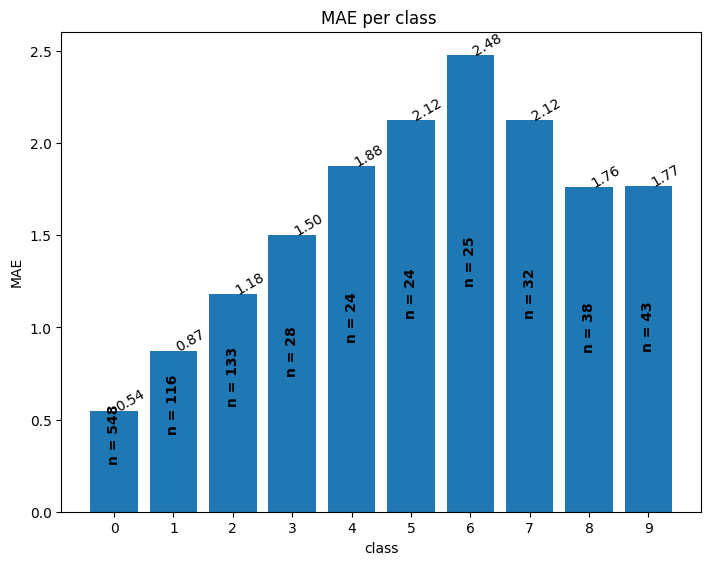

-----------|class error-MAE| difference-----------
mean: 0.45143475622983553
std: 0.38139826563621393
coefficient of variation (std/mean): 0.8448580007916704

----------normalized difference-------------
mean: 0.3689258720885012
std: 0.31168997473301463


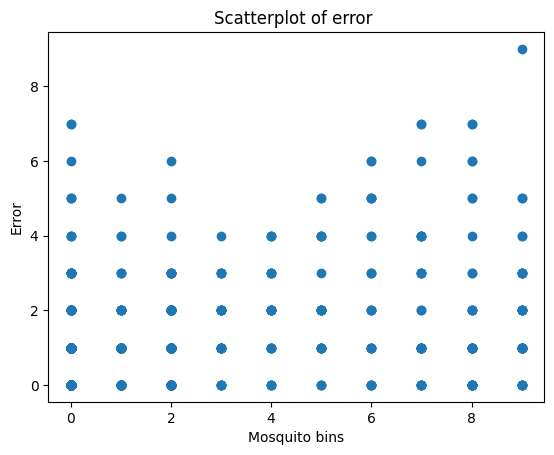

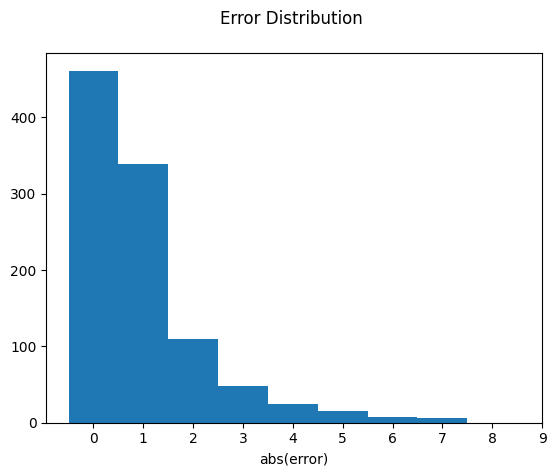

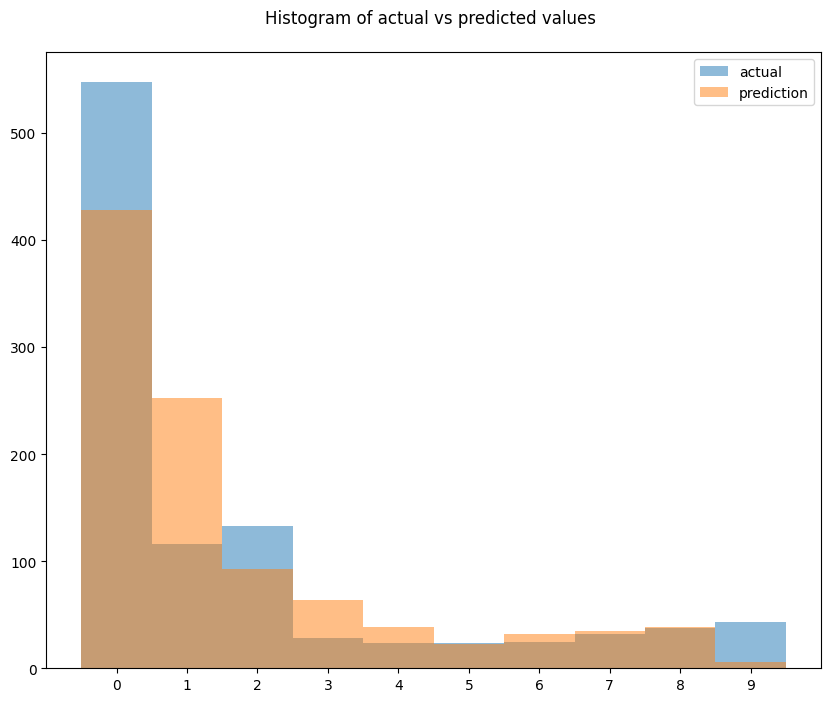

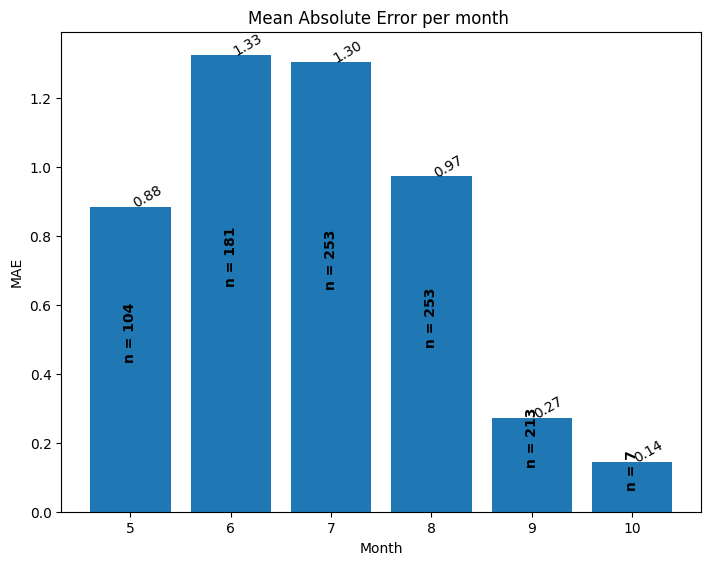

prediction
0    9
1    5
3    1
4    2
7    1
9    1
Name: count, dtype: int64

Low risk category stations: 14
Medium risk category stations: 3
High risk category stations: 2
#===========================================
Predictions with/without entomological features
#===========================================
prediction
0    3130
1    2007
2     902
3     685
4     561
5     393
6     212
7     109
8      31
9      17
Name: count, dtype: int64

Low risk category stations: 5137
Medium risk category stations: 2541
High risk category stations: 369


In [8]:
#=====================================================================
# Automation models without or with/without entomological data
#=====================================================================

# Spit to train and test based on date of predictions
test = data.loc[data[date_col] >= pd.to_datetime(date)]
data = data.loc[data[date_col] < pd.to_datetime(date)]

# Delete from test set stations that are not used during the last 3 years
# test = unused_stations(data, test, period=3)

#Remove features that are more 40% filled with nan values in the test set
data, test = remove_nan_features(data, test, 0.3)

# set the only_env as True if there are no mosquitoes for the forecast month
only_env=None    
if len(test.dropna(subset=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                           'mosq_sum_previous_2weeks','previous_mosq_measure']).drop(columns=['mosq_now']).dropna())>0:
    only_env=False
elif len(test.drop(columns=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                           'mosq_sum_previous_2weeks', 'previous_mosq_measure', 'mosq_now']).dropna())>0:
    only_env=True
else:
    print('No data left for prediction')
    
num_class = 1
hidden_layers = [264,128,128,64,32]
learning_rate = 0.001
epochs = 50
batch_size = 128
dropout = 0.2
# set the early stop argument as early_stop = (tolerance, min_delta)
early_stop = None
#set the transformation actions on the data. Options are 'augmentation', 'normalization', 'log', 'scaling'
transformation_list = ['scaling']
#set the data for embeddings e.g. data[['col', 'col2']]
embedded_data = None
#set the boolean for plotting feature importance (!very time consuming!)
fi = False
    
if only_env != None:
    # Run first without entomological features
    print("#===========================================")
    print("Predictions without entomological features")
    print("#===========================================")
    print()
    data_env = data.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                          'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)
    test_env = test.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                          'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)
    del data_env['null_island_distance']
#     del data_env['x']
#     del data_env['y']
    del data_env['vert_distance']
    
    del test_env['null_island_distance']
#     del test_env['x']
#     del test_env['y']
    del test_env['vert_distance']

    data_env = data_env.dropna().reset_index(drop=True)
    test_env = test_env.dropna(subset=test_env.columns.difference(['mosq_now'])).reset_index(drop=True)

    
    model = FeedforwardNeuralNetModel(num_features=len(data_env.iloc[0,:])-2, num_class=num_class,
                                      hidden_layers = hidden_layers, model_type=model_type,
                                      learning_rate = learning_rate, epochs = epochs, batch_size = batch_size,
                                      dropout = dropout, embedding_data=embedded_data, 
                                      transformation_list=transformation_list, early_stop = early_stop, 
                                      l1_weight=0, l2_weight=0, weights=False)

    evaluate_nn(model, data_env, fi = fi)

    predictions_env = give_predictions_nn(model, data_env, test_env, env = True, filepath = path, case = title,
                                          export = only_env)

    # Run with entomological features if at least one station has mosquitos number
    if not only_env:
        print("#===========================================")
        print("Predictions with entomological features")
        print("#===========================================")
        print()
        
        data_entom = data.dropna().reset_index(drop=True)
        test_entom = test.dropna(subset=test.columns.difference(['mosq_now'])).reset_index(drop=True)
        
        model = FeedforwardNeuralNetModel(num_features=len(data_entom.iloc[0,:])-2, num_class=num_class,
                                          hidden_layers = hidden_layers, model_type=model_type,
                                          learning_rate = learning_rate, epochs = epochs, batch_size = batch_size,
                                          dropout = dropout, embedding_data=embedded_data, 
                                          transformation_list=transformation_list, early_stop = early_stop, 
                                          l1_weight=0, l2_weight=0, weights=False)
        
        evaluate_nn(model, data_entom, fi = fi)

        predictions_entom = give_predictions_nn(model, data_entom, test_entom, env = False, filepath = path,
                                                case = title, export = False)

        print("#===========================================")
        print("Predictions with/without entomological features")
        print("#===========================================")
        merge_predictions(predictions_env,predictions_entom,path,title,export=True)

In [ ]:
#=====================================================================
# Automation models without or with/without entomological data
#=====================================================================

data = data.drop(columns = ['acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan'])

# Spit to train and test based on date of predictions
test = data.loc[data[date_col] >= pd.to_datetime(date)]
data = data.loc[data[date_col] < pd.to_datetime(date)]

# Delete from test set stations that are not used during the last 3 years
# test = unused_stations(data, test, period=3)

#Remove features that are more 40% filled with nan values in the test set
data, test = remove_nan_features(data, test, 0.3)

# set the only_env as True if there are no mosquitoes for the forecast month
only_env=None    
if len(test.dropna(subset=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                           'mosq_sum_previous_2weeks','previous_mosq_measure']).drop(columns=['mosq_now']).dropna())>0:
    only_env=False
elif len(test.drop(columns=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                           'mosq_sum_previous_2weeks', 'previous_mosq_measure', 'mosq_now']).dropna())>0:
    only_env=True
else:
    print('No data left for prediction')
    

learning_rate = 0.3
# set the early stop argument as early_stop = (tolerance, min_delta)
early_stop = None
#set the transformation actions on the data. Options are 'augmentation', 'normalization', 'log', 'scaling'
transformation_list = []
#set the data for embeddings e.g. data[['col', 'col2']]
embedded_data = None
#set the boolean for plotting feature importance (!very time consuming!)
fi = False
    
if only_env != None:
    # Run first without entomological features
    print("#===========================================")
    print("Predictions without entomological features")
    print("#===========================================")
    print()
    data_env = data.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                          'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)
    test_env = test.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                          'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)
    del data_env['null_island_distance']
    del data_env['x']
    del data_env['y']
    del data_env['vert_distance']
    
    data_env = data_env.dropna().reset_index(drop=True)
    test_env = test_env.dropna(subset=test_env.columns.difference(['mosq_now'])).reset_index(drop=True)

    model = Xgboost_model(model_type = model_type, learning_rate = learning_rate,
                          embedding_data = embedded_data,  transformation_list = transformation_list,
                          early_stop = False, l1_weight = 0, l2_weight = 0, weights = False)
    
    evaluate_xgboost(model, data_env, fi = fi)

    predictions_env = give_predictions_xgboost(model, data_env, test_env, env = True, filepath = path, case = title,
                                               fi = fi, export = only_env)


    # Run with entomological features if at least one station has mosquitos number
    if not only_env:
        print("#===========================================")
        print("Predictions with entomological features")
        print("#===========================================")
        print()
        
        data_entom = data.dropna().reset_index(drop=True)
        test_entom = test.dropna(subset=test.columns.difference(['mosq_now'])).reset_index(drop=True)
        
        model = Xgboost_model(model_type = model_type, learning_rate = learning_rate,
                              embedding_data = embedded_data,  transformation_list = transformation_list,
                              early_stop = False, l1_weight = 0, l2_weight = 0, weights = False)
    
        evaluate_xgboost(model, data_entom, fi = fi)

        predictions_entom = give_predictions_xgboost(model, data_entom, test_entom, env = False, filepath = path,
                                                     fi = fi, case = title, export = only_env)

        print("#===========================================")
        print("Predictions with/without entomological features")
        print("#===========================================")
        merge_predictions(predictions_env,predictions_entom, path, title, export=True)